# Classification

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

### Define and train model, get calibration probabilities

In [2]:
# Generate synthetic dataset
X, y = datasets.make_classification(n_samples=10000, n_features=20, n_classes=10, n_informative=15, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

model = MLPClassifier(hidden_layer_sizes=(50,5), activation='relu', solver='adam', max_iter=5000, random_state=42)
model.fit(X_train, y_train)

calib_probs = model.predict_proba(X_calib)
test_probs = model.predict_proba(X_test)
CP = {"TPS": {}, "APS": {}, "RAPS": {}, "DAPS": {}}

# Print set sizes
print(f"Training set size: {len(y_train)}")
print(f"Calibration set size: {len(y_calib)}")
print(f"Test set size: {len(y_test)}")

Training set size: 6000
Calibration set size: 2000
Test set size: 2000


### Thresshold predictive sets (TPS)

In [3]:
def TPS(calib_probs, y_calib, test_probs, alpha=0.25):

    # Calibration scores
    n = len(y_calib)
    q_level = np.ceil((n+1)*(1-alpha))/n

    cal_scores = 1-calib_probs[np.arange(n),y_calib]
    q_hat = np.quantile(cal_scores, q_level, method='higher')

    # Compute prediction sets and empirical coverage
    prediction_sets = test_probs >= (1-q_hat)
    empirical_coverage = prediction_sets[np.arange(len(test_probs)), y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[np.arange(len(test_probs)), y_test][np.sum(prediction_sets, axis=1) == 1])

    # Define prediction sets
    preds = {}
    for i in range(len(test_probs)):
        preds[i] = [int(j) for j in np.where(test_probs[i] >=  (1-q_hat))[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate

### Adaptive prediction sets

In [4]:
def APS(calib_probs, y_calib, test_probs, alpha=0.25):
    n = len(y_calib)
    q_level = np.ceil((n+1)*(1-alpha))/n

    # Adaptive Prediction Sets (APS)
    # Compute calibration scores
    true_prob = calib_probs[np.arange(n), y_calib]                                              # true class probabilities
    cal_pi = calib_probs.argsort(1)[:,::-1]                                                     # Indices that would sort probs descending
    cal_srt = np.take_along_axis(calib_probs, cal_pi, axis=1).cumsum(axis=1)                    # Sorted cumulative sums
    cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), y_calib] # Get scores for true class

    # Break ties randomly
    u = np.random.uniform(0,1,size=n)
    cal_scores = cal_scores - u * true_prob   # Subtract random fraction of true class prob to break ties


    # Get the score quantile
    q_hat = np.quantile(cal_scores, q_level, method='higher')

    # Get prediction sets for test data
    test_pi = test_probs.argsort(1)[:,::-1]                                     # Indices that would sort test probs descending
    test_srt = np.take_along_axis(test_probs, test_pi, axis=1).cumsum(axis=1)   # Sorted cumulative sums

    # Define prediction sets
    mask = test_srt < q_hat                                                         # classes strictly below qhat
    first_cross = (test_srt >= q_hat).argmax(axis=1)                                # index of first crossing
    mask[np.arange(len(mask)), first_cross] = True                                  # ensure inclusion of crossing class
    prediction_sets = np.take_along_axis(mask, test_pi.argsort(axis=1), axis=1) # Get prediction sets, all values with cumsum less than q_hat

    empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[np.arange(len(test_probs)), y_test][np.sum(prediction_sets, axis=1) == 1])

    preds = {}
    for i in range(len(test_probs)):
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


### RAPS

In [5]:
def RAPS(calib_probs, y_calib, test_probs, alpha=0.25, lam_reg=0.3, k_reg=2, disallow_zero_sets=True, rand=True):
    n = len(y_calib)

    # Regularization vector
    reg_vec = np.array(k_reg*[0,] + (calib_probs.shape[1]-k_reg)*[lam_reg,])[None,:]


    # Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
    cal_pi = calib_probs.argsort(1)[:,::-1]; 
    cal_srt = np.take_along_axis(calib_probs,cal_pi,axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_L = np.where(cal_pi == y_calib[:,None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]

    # Get the score quantile
    q_hat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')
    
    # Deploy
    n_val = test_probs.shape[0]
    val_pi = test_probs.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(test_probs,val_pi,axis=1)
    val_srt_reg = val_srt + reg_vec
    indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= q_hat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= q_hat
    if disallow_zero_sets: indicators[:,0] = True
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[np.arange(n_val),y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[np.arange(len(test_probs)), y_test][np.sum(prediction_sets, axis=1) == 1])
    

    preds = {}
    for i in range(len(test_probs)):
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


# Compare methods


### Final boss: DAPS

In [6]:
### Method ###
# 0 - PCA ?
# 1 - cluster data
# 2 - compute base scores
# 3 - Update scores based on diffusion
# 4 - ???
# 5 - profit

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Fit PCA and clustering model on training data
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
cluster_model = KMeans(n_clusters=10, random_state=42)
cluster_model.fit(X_train_pca)


def DAPS(calib_probs, y_calib, test_probs, pca, cluster_model, alpha=0.25, lam_reg=0.3, k_reg=2, beta = 0.1, disallow_zero_sets=True, rand=True):
    n = len(y_calib)
    q_level = np.ceil((n+1)*(1-alpha))/n
    n_test = len(test_probs)

    # Regularization vector
    reg_vec = np.array(k_reg*[0,] + (calib_probs.shape[1]-k_reg)*[lam_reg,])[None,:]


    # Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
    cal_pi = calib_probs.argsort(1)[:,::-1]; 
    cal_srt = np.take_along_axis(calib_probs,cal_pi,axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_L = np.where(cal_pi == y_calib[:,None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]



    # Cluster
    X_calib_pca = pca.transform(X_calib)
    calib_clusters = cluster_model.predict(X_calib_pca)

    diff_scores = cal_scores.copy()
    cluster_scores = {}

    for cluster in np.unique(calib_clusters):
        cluster_scores[cluster] = np.mean(cal_scores[calib_clusters == cluster], axis=0)
        indices = np.where(calib_clusters == cluster)[0]
        diff_scores[indices] = (1 - beta) * cal_scores[indices] + beta * cluster_scores[cluster]


    # Get the score quantile
    q_hat = np.quantile(diff_scores, q_level, method='higher')
    
        
    # Get prediction sets for test data
    test_clusters = cluster_model.predict(pca.transform(X_test))
    cluster_scores_test = {}
    test_pi = test_probs.argsort(1)[:,::-1]
    test_srt = np.take_along_axis(test_probs,test_pi,axis=1)
    test_scores_base = test_srt + reg_vec
    test_scores = test_scores_base.copy()
    
    for cluster in np.unique(test_clusters):
        cluster_scores_test[cluster] = np.mean(test_scores_base[test_clusters == cluster], axis=0)
        indices = np.where(test_clusters == cluster)[0]
        test_scores[indices] = (1 - beta) * test_scores_base[indices] + beta * cluster_scores_test[cluster]

    # Define prediction sets
    # Deploy
    indicators = (test_scores.cumsum(axis=1) - np.random.rand(n_test,1)*test_scores) <= q_hat if rand else test_scores.cumsum(axis=1) - test_scores <= q_hat
    if disallow_zero_sets: indicators[:,0] = True
    prediction_sets = np.take_along_axis(indicators,test_pi.argsort(axis=1),axis=1)

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[np.arange(n_test),y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[np.arange(len(test_probs)), y_test][np.sum(prediction_sets, axis=1) == 1])
        

    preds = {}
    for i in range(len(test_probs)):
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


In [7]:
# For each method, fill out CP dictionary
CP["TPS"]["cal_scores"], CP["TPS"]["q_hat"], CP["TPS"]["preds"], CP["TPS"]["empirical_coverage"], CP["TPS"]["singleton_rate"], CP["TPS"]["singleton_hit_rate"] = TPS(calib_probs, y_calib, test_probs, alpha=0.1)
CP["APS"]["cal_scores"], CP["APS"]["q_hat"], CP["APS"]["preds"], CP["APS"]["empirical_coverage"], CP["APS"]["singleton_rate"], CP["APS"]["singleton_hit_rate"] = APS(calib_probs, y_calib, test_probs, alpha=0.1)
CP["RAPS"]["cal_scores"], CP["RAPS"]["q_hat"], CP["RAPS"]["preds"], CP["RAPS"]["empirical_coverage"], CP["RAPS"]["singleton_rate"], CP["RAPS"]["singleton_hit_rate"] = RAPS(calib_probs, y_calib, test_probs, alpha=0.1, lam_reg=0.3, k_reg=2, disallow_zero_sets=True, rand=True)
CP["DAPS"]["cal_scores"], CP["DAPS"]["q_hat"], CP["DAPS"]["preds"], CP["DAPS"]["empirical_coverage"], CP["DAPS"]["singleton_rate"], CP["DAPS"]["singleton_hit_rate"] = DAPS(calib_probs, y_calib, test_probs, pca, cluster_model, alpha=0.1, lam_reg=0.3, k_reg=2, beta = 0.1, disallow_zero_sets=True, rand=True)

c:\Users\jacob\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jacob\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jacob\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jacob\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
for method in CP.keys():
    print(f"{method} empirical coverage: {CP[method]['empirical_coverage']}")

TPS empirical coverage: 0.909
APS empirical coverage: 0.9355
RAPS empirical coverage: 0.9155
DAPS empirical coverage: 0.901


In [9]:
# Average size of prediction sets
for method in CP.keys():
    sizes = [len(s) for s in CP[method]['preds'].values()]
    avg_size = np.mean(sizes)
    print(f"{method} average prediction set size: {np.round(avg_size, 3)}")

TPS average prediction set size: 3.094
APS average prediction set size: 3.738
RAPS average prediction set size: 3.73
DAPS average prediction set size: 3.422


In [10]:
# Singleton rates and hit ratios
for method in CP.keys():
    singleton_rate = CP[method]['singleton_rate']
    singleton_hit_ratio = CP[method]['singleton_hit_rate']
    print(f"{method} singleton rate: {np.round(singleton_rate, 3)}, singleton hit ratio: {np.round(singleton_hit_ratio, 3)}")

TPS singleton rate: 0.148, singleton hit ratio: 0.905
APS singleton rate: 0.104, singleton hit ratio: 0.933
RAPS singleton rate: 0.0, singleton hit ratio: nan
DAPS singleton rate: 0.0, singleton hit ratio: nan


In [11]:
for i in range(5):
    print(f"Test example {i}, true label: {y_test[i]}")
    print(f"  TPS prediction set:  {CP['TPS']['preds'][i]}")
    print(f"  APS prediction set:  {CP['APS']['preds'][i]}")
    print(f"  RAPS prediction set: {CP['RAPS']['preds'][i]}")
    print(f"  DAPS prediction set: {CP['DAPS']['preds'][i]}")
    print()

Test example 0, true label: 8
  TPS prediction set:  [6, 7, 8, 9]
  APS prediction set:  [6, 7, 8, 9]
  RAPS prediction set: [6, 7, 8, 9]
  DAPS prediction set: [6, 7, 8, 9]

Test example 1, true label: 5
  TPS prediction set:  [3, 5]
  APS prediction set:  [3, 5]
  RAPS prediction set: [2, 3, 5]
  DAPS prediction set: [2, 3, 5]

Test example 2, true label: 7
  TPS prediction set:  [6, 7, 9]
  APS prediction set:  [6, 7, 9]
  RAPS prediction set: [6, 7, 9]
  DAPS prediction set: [6, 7, 8, 9]

Test example 3, true label: 5
  TPS prediction set:  [5, 6, 7, 8, 9]
  APS prediction set:  [4, 5, 6, 7, 8, 9]
  RAPS prediction set: [6, 7, 8, 9]
  DAPS prediction set: [6, 7, 8, 9]

Test example 4, true label: 3
  TPS prediction set:  [2, 3]
  APS prediction set:  [2, 3]
  RAPS prediction set: [2, 3, 5, 9]
  DAPS prediction set: [2, 3, 5]



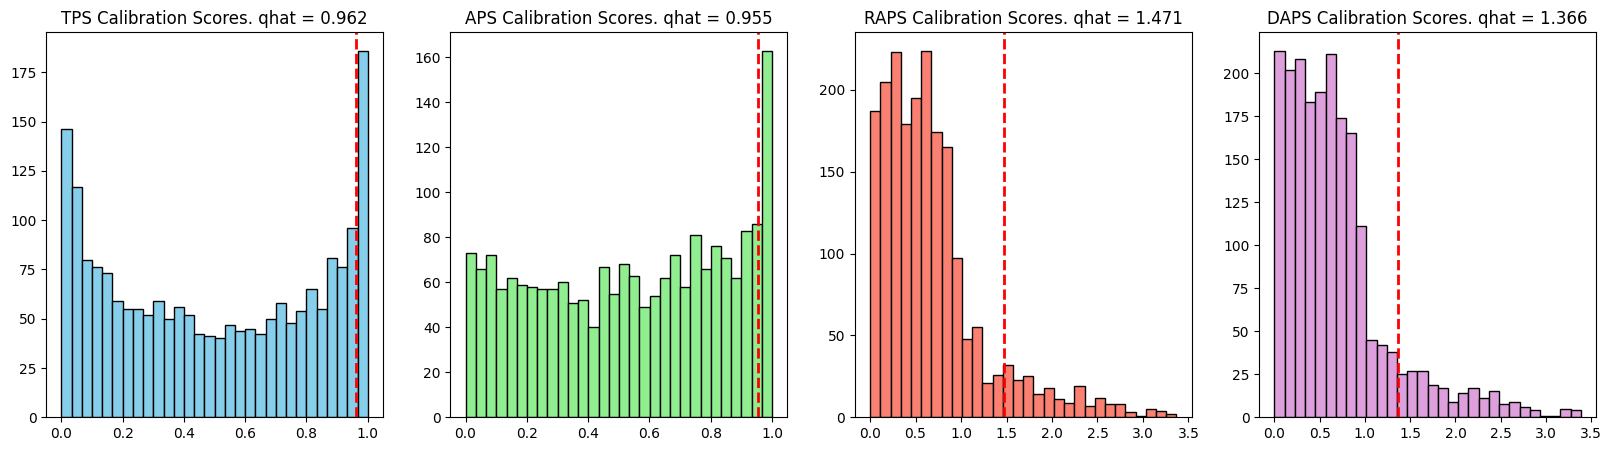

In [12]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

ax[0].hist(CP["TPS"]['cal_scores'], bins=30, color='skyblue', edgecolor='black')
ax[0].axvline(CP["TPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[0].set_title('TPS Calibration Scores. qhat = {:.3f}'.format(CP["TPS"]['q_hat']))

ax[1].hist(CP["APS"]['cal_scores'], bins=30, color='lightgreen', edgecolor='black')
ax[1].axvline(CP["APS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[1].set_title('APS Calibration Scores. qhat = {:.3f}'.format(CP["APS"]['q_hat']))

ax[2].hist(CP["RAPS"]['cal_scores'], bins=30, color='salmon', edgecolor='black')
ax[2].axvline(CP["RAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[2].set_title('RAPS Calibration Scores. qhat = {:.3f}'.format(CP["RAPS"]['q_hat']))

ax[3].hist(CP["DAPS"]['cal_scores'], bins=30, color='plum', edgecolor='black')
ax[3].axvline(CP["DAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[3].set_title('DAPS Calibration Scores. qhat = {:.3f}'.format(CP["DAPS"]['q_hat']))

plt.show()